# Introduction to this Kernel 

The Sole intention of this kernel is to provide the reader with a basic yet robust to all situations pipeline for approaching almost any Image Classifiaction Problem. This is a very basic and generalized kernel and I've tried to keep it easily intergrable with almost any other pytorch code. Happy Kaggling :-)

**If you like the content in this notebook, Do Upvote the notebook and show me your support**

Note: I have shown this kernel with no feature engineering no hyperparameter tuning, if you use N_tile feature engineering along with some other preprocessing and tune the hyper parameters well, you can get a decent score

# Problem Statement in a nutshell

Given some 10,000 images predict the class they belong to, where the class is isup_score. We are given a csv file by the name train, which contains the names of the images and some extra information. 

It can be interpreted like a normal image classification task. Simple isn't it? 

# Loading the Important Libraries

First things first, lets load all the important libraries first

In [1]:
#Basic Python and Machine learning libraries
import os, sys, warnings, random, time, cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import skimage.io
from PIL import Image
from scipy import stats
from sklearn import metrics
from sklearn.model_selection import StratifiedKFold
from IPython.display import display
from tqdm import tqdm_notebook as tqdm

#Pytorch and Albumentations(Data Augmentation Library)
import torch
import albumentations
from albumentations.pytorch import ToTensorV2
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.functional import F 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models

#A piece of code that will allow me to use and retrain Efficient Nets from my input folder
package_path = '../input/efficientnet-pytorch/EfficientNet-PyTorch/EfficientNet-PyTorch-master'
sys.path.append(package_path)
from efficientnet_pytorch import model as enet

#Mandatory Lines of code when working with jupyter notebooks
%matplotlib inline
warnings.filterwarnings('ignore')

In [2]:
# I Just wanted my plots to look neat hence fixing some plot styles
plt.style.use('seaborn-whitegrid')
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['text.color'] = 'black'
plt.rcParams['axes.labelcolor']= 'black'
plt.rcParams['xtick.color'] = 'black'
plt.rcParams['ytick.color'] = 'black'
plt.rcParams['font.size'] = 12

# Fixing Config

Putting some global variables in CONFIG class so that whenever I wish to make a change in their values, I've to change them here only, not everywhere in my code

In [3]:
class Config:
    
    DEBUG = False
    pwd = '/kaggle/working/'
    data_dir = '../input/prostate-cancer-grade-assessment/'
    train_img_dir = os.path.join(data_dir, 'train_images')
    test_img_dir = os.path.join(data_dir, 'test_images')
    num_images_to_plot = 16
    num_folds = 2 if DEBUG else 5
    height = 256
    width = 256
    out_dim = 6
    batch_size = 16
    num_workers = 4
    num_epochs = 2 if DEBUG else 10
    SEED = 713
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    #Image-net standard mean and std
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]
    pretrainied_models = {
        'efficientnet-b0': '../input/efficientnet-pytorch/efficientnet-b0-08094119.pth'
    }

In [4]:
# Fixing seed so that our results are always reproducible
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(Config.SEED)

Let's Just Peek into our train.csv

In [5]:
train_df = pd.read_csv(Config.data_dir+'train.csv')
train_df = train_df.sample(100).reset_index(drop=True) if Config.DEBUG else train_df
display(train_df.head())
len(train_df)

,image_id,data_provider,isup_grade,gleason_score
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0


10616

Basically DEBUG = True ensures that we can take a quick test run if our code is working or not, for Committing and Submitting keep DEBUG = False

# Building Dataset

Now we are going to make a Class Build_Dataset, which inherits from torch.utils.data.Data set and returns us pytorch Dataset object.

If the above line is too technical for you, then simply what this class does is goes through our image directory and keeps all images ready for use whenever we need to use it, without throwing them into RAM. Imagine throwing 380GB in our RAM, catastrophic isn't it? This is why you should learn to build your custom dataset classes.

In this class it'll return me the image and the label corresponding to the index in my pandas dataframe whenever I request it to do so, we just need to over write the three methods of the pytorch's Dataset class, the __ init__() method, the __ len__() method and __ getitem__() method

In [6]:
class Build_Dataset(Dataset):
    '''Builds Dataset to be fed to Neural Network
       :param df: train_df or test_df
       :param resize: tuple, eg(256, 256)
       :param mode: string train or test 
       :param: augmentations: Image augmentations
    '''
    #Here I am defining my constructor
    def __init__(self, df, resize=None, mode='train', augmentations=None):
        self.df = df
        self.resize = resize
        self.mode = mode
        self.augmentations = augmentations
      
    # This method returns the total length of the dataset
    def __len__(self):
        return len(self.df)
    
    # This method returns (image, label) at index idx
    def __getitem__(self, idx):
        if self.mode == 'train':
            img_path = os.path.join(Config.train_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)
            label = self.df['isup_grade'].values[idx]
            
        if self.mode == 'test':
            img_path = os.path.join(Config.test_img_dir, self.df['image_id'].values[idx]) + '.tiff'
            image = skimage.io.MultiImage(img_path)
            label = -1
            
        if self.resize is not None:
            image = cv2.resize(image[-1], (self.resize[0], self.resize[1]))
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
        image = np.array(image)
        
        if self.augmentations is not None:
            augmented = self.augmentations(image=image)
            image = augmented["image"]
            
        return image, label
            

# Basic EDA time

Let's have a glance at the Images given, this will also make us sure that my Build_Dataset code is working(I'm always skeptical about my code, specially when it's so long)

In [7]:
# The below code will plot down some images for you, given a list of images
def plot_images(images):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize=(20,10))
    for i in range(rows*cols):
        ax = fig.add_subplot(rows, cols, i+1)
        ax.set_title('ISUP: '+str(images[i][1]))
        ax.imshow(np.array(images[i][0]))
        ax.axis('off')

Well if you are anything like me who has no domain experience in biology(I even skipped my biology lectures and exams but that's a different story all together), It's hard to say which images are of benign cells and which images are of cancerous(my best guess is all kinda thick slides are cancerous :p). Even if it wasn't a code competition, hand labelling was never an option for me :-/

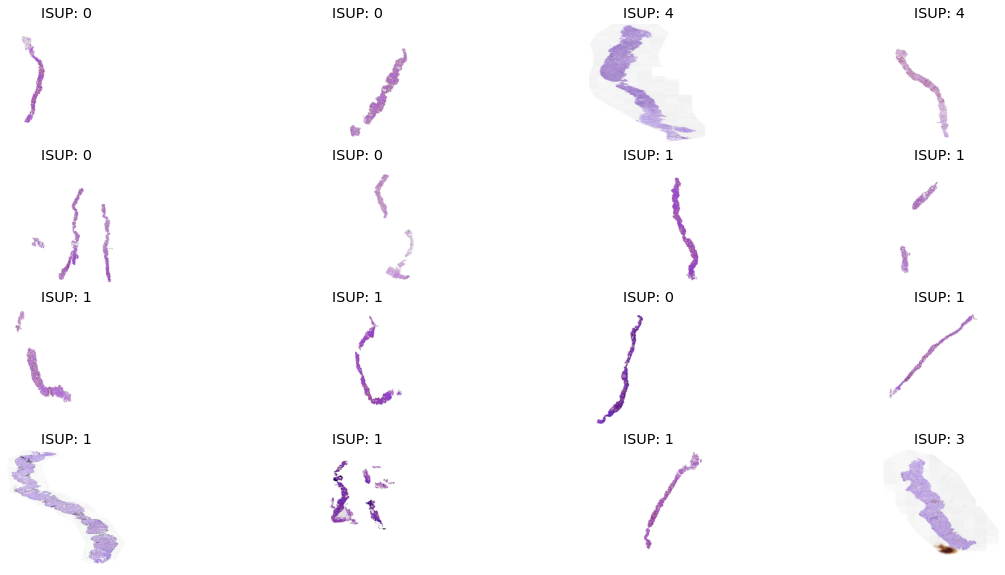

In [8]:
train_data = Build_Dataset(train_df, resize=(Config.height, Config.width), mode='train')
images = [(image, label) for image, label in [train_data[i] for i in range(Config.num_images_to_plot)]] 
plot_images(images)

Now let's have a look how is our target class distribution, I just hope that it is not heavily skewed

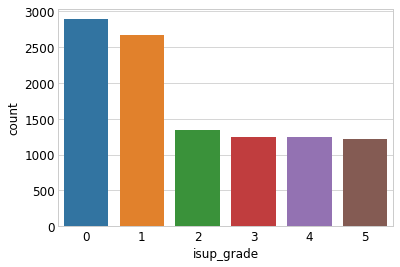

In [9]:
sns.countplot(train_df.isup_grade)

Okay, that's an imbalanced distribution, when we see imbalanced classes, what do we do? 

Stratified K-fold cross validation, right? Let's create some folds now

In [10]:
skf = StratifiedKFold(Config.num_folds, shuffle=True, random_state=Config.SEED)
train_df['fold'] = -1
for i, (tr_idx, val_idx) in enumerate(skf.split(train_df, train_df['isup_grade'])):
    train_df.loc[val_idx, 'fold'] = i
train_df.head()

,image_id,data_provider,isup_grade,gleason_score,fold
0,0005f7aaab2800f6170c399693a96917,karolinska,0,0+0,4
1,000920ad0b612851f8e01bcc880d9b3d,karolinska,0,0+0,1
2,0018ae58b01bdadc8e347995b69f99aa,radboud,4,4+4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,karolinska,4,4+4,0
4,001d865e65ef5d2579c190a0e0350d8f,karolinska,0,0+0,2


# Pre-processing The Data

Ahh The Preprocessing, commomly hated by all researchers.

Let's for the sake of simple kernel, not dive into the preprocessing and delete 'data_provider' and 'gleason_score' from training data to make our baseline pipeline simpler

In [11]:
train_df.drop(columns=['data_provider', 'gleason_score'], inplace=True)
train_df.head()

,image_id,isup_grade,fold
0,0005f7aaab2800f6170c399693a96917,0,4
1,000920ad0b612851f8e01bcc880d9b3d,0,1
2,0018ae58b01bdadc8e347995b69f99aa,4,0
3,001c62abd11fa4b57bf7a6c603a11bb9,4,0
4,001d865e65ef5d2579c190a0e0350d8f,0,2


Let's apply some augmentation to our images, normalize them and convert them to pytorch tensors. All standard stuff

It is so simple with the help of Albumentation

In [12]:
#Defining train and test transforms
train_transforms = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.VerticalFlip(p=0.5),
    albumentations.Normalize(mean=Config.mean, std=Config.std, always_apply=True),
    albumentations.pytorch.ToTensorV2(),
])
test_transforms = albumentations.Compose([
    albumentations.Normalize(mean=Config.mean, std=Config.std, always_apply=True),
    ToTensorV2(),
])

# Building Model

***Spoiler Alert*** : Fun Begins

Let's use the pretrained Efficient Net b-0. Whenever we write our own custom model class, we need to inherit from nn.Module and overwrite __ init__() and forward() method

In [13]:
class enetv2(nn.Module):
    def __init__(self, backbone, out_dim):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        self.enet.load_state_dict(torch.load(Config.pretrainied_models[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
    
    def extract(self, x):
        return self.enet(x)
    
    def forward(self, x):
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [14]:
#These are just 2 helpful functions I like using
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

model = enetv2('efficientnet-b0', Config.out_dim).to(Config.device)
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,015,234 trainable parameters


# Defining Training and Validation epochs

It looks pretty complicated but it is all pretty simple stuff.

All you need to do in training is

- put our model into train mode
- iterate over our dataloader, returning batches of (image, label)
- place the batch on to our GPU, if we have one
- clear the gradients calculated from the last batch
- pass our batch of images, x, through to model to get predictions, y_pred
- calculate the loss between our predictions and the actual labels
- calculate and backpropagate the gradients of each parameter
- update the parameters by taking an optimizer step
- update our metrics

All you need to do in validation is 

- put our model into evaluation mode with model.eval()
- wrap the iterations inside a with torch.no_grad()
- pass our batch of images, x, through to model to get predictions, y_pred
- do not zero gradients as we are not calculating any
- do not calculate gradients as we are not updating parameters
- do not take an optimizer step as we are not calculating gradients
- update our metrics

In [15]:
def train(model, iterator, optimizer, criterion, device):
    
    epoch_loss = 0
    model.train()
    
    for (x, y) in iterator:
        
        x = x.to(device, dtype=torch.float)
        y = y.to(device, dtype=torch.long)
        optimizer.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        loss_np = loss.detach().cpu().numpy()
        epoch_loss += loss_np
        
    return epoch_loss/len(iterator)

def evaluate(model, iterator, criterion, device):
    
    epoch_loss = 0
    preds = []
    preds = np.array(preds)
    targets = []
    targets = np.array(targets)
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:
        
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            y_pred = model(x)
            loss = criterion(y_pred, y)
            loss_np = loss.detach().cpu().numpy()
            epoch_loss += loss_np
            preds = np.append(preds, np.argmax(y_pred.detach().cpu().numpy(), axis = 1))
            targets = np.append(targets, y.detach().cpu().numpy())
            
    return epoch_loss/len(iterator), metrics.cohen_kappa_score(targets, preds, weights='quadratic')

# Defining Training Loop

Let's finally define our Training loop and now is the time to put out train and evaluate function to use

I am returning a pandas dataframe object as I intend to visualize the training curves

In [16]:
def fit_model(model, model_name, train_iterator, valid_iterator, optimizer, loss_criterion, device, num_epochs, fold):
    """ Fits a dataset to model"""
    #Setting best validation loss to infinity :p
    best_valid_loss = float('inf')
    
    train_losses = []
    valid_losses = []
    valid_metric_scores = []
    
    #Let's loop through our data
    for epoch in range(num_epochs):
    
        start_time = time.time()
    
        train_loss = train(model, train_iterator, optimizer, loss_criterion, device)
        valid_loss, valid_metric_score = evaluate(model, valid_iterator, loss_criterion, device)
        
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        valid_metric_scores.append(valid_metric_score)

        #Let's keep updating our model, so that we save only the best one at the end
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'{model_name}_fold_{fold}.pt')
    
        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        
        #Printing and returning some important statistics
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Metric Score: {valid_metric_score:.3f}')
        
    return pd.DataFrame({f'{model_name}_fold_{fold}_Training_Loss':train_losses,  
                        f'{model_name}_fold_{fold}_Validation_Loss':valid_losses, 
                        f'{model_name}_fold_{fold}_Valid_Metric_Score':valid_metric_scores})

In [17]:
#This will simply plot the training statistics we returned
def plot_training_statistics(train_stats, model_name, fold):
    
    fig, axes = plt.subplots(2, figsize=(15,15))
    axes[0].plot(train_stats[f'{model_name}_fold_{fold}_Training_Loss'], label=f'{model_name}_fold_{fold}_Training_Loss')
    axes[0].plot(train_stats[f'{model_name}_fold_{fold}_Validation_Loss'], label=f'{model_name}_fold_{fold}_Validation_Loss')
    axes[1].plot(train_stats[f'{model_name}_fold_{fold}_Valid_Metric_Score'], label=f'{model_name}_fold_{fold}_Valid_Metric_Score')
    
    axes[0].set_xlabel("Number of Epochs"), axes[0].set_ylabel("Loss")
    axes[1].set_xlabel("Number of Epochs"), axes[1].set_ylabel("Score on Metric")
    
    axes[0].legend(), axes[1].legend()

# Training with K-Fold CV

Finally The moment we have been waiting for has arrived. *Let's Train The Model*

This will output us k different models, by running the training look k times, so beware if you some computing constraints. But nevertheless, even I don't have a GPU at home or money and good stable internet connetion to work on cloud(poor me :-(  ). It works fine for me on the kaggle kernel, I hope it's gonna work well for you too.

Fitting on Fold 1
Epoch: 01 | Epoch Time: 3m 51s
	Train Loss: 1.529
	 Val. Loss: 1.567 |  Val. Metric Score: 0.536
Epoch: 02 | Epoch Time: 3m 40s
	Train Loss: 1.436
	 Val. Loss: 1.422 |  Val. Metric Score: 0.590
Epoch: 03 | Epoch Time: 3m 31s
	Train Loss: 1.387
	 Val. Loss: 1.432 |  Val. Metric Score: 0.499
Epoch: 04 | Epoch Time: 3m 32s
	Train Loss: 1.360
	 Val. Loss: 1.578 |  Val. Metric Score: 0.398
Epoch: 05 | Epoch Time: 3m 38s
	Train Loss: 1.338
	 Val. Loss: 1.396 |  Val. Metric Score: 0.533
Epoch: 06 | Epoch Time: 3m 46s
	Train Loss: 1.312
	 Val. Loss: 1.475 |  Val. Metric Score: 0.538
Epoch: 07 | Epoch Time: 3m 48s
	Train Loss: 1.295
	 Val. Loss: 1.491 |  Val. Metric Score: 0.527
Epoch: 08 | Epoch Time: 3m 49s
	Train Loss: 1.283
	 Val. Loss: 1.464 |  Val. Metric Score: 0.551
Epoch: 09 | Epoch Time: 3m 49s
	Train Loss: 1.256
	 Val. Loss: 1.522 |  Val. Metric Score: 0.603
Epoch: 10 | Epoch Time: 3m 50s
	Train Loss: 1.239
	 Val. Loss: 1.354 |  Val. Metric Score: 0.646


----------

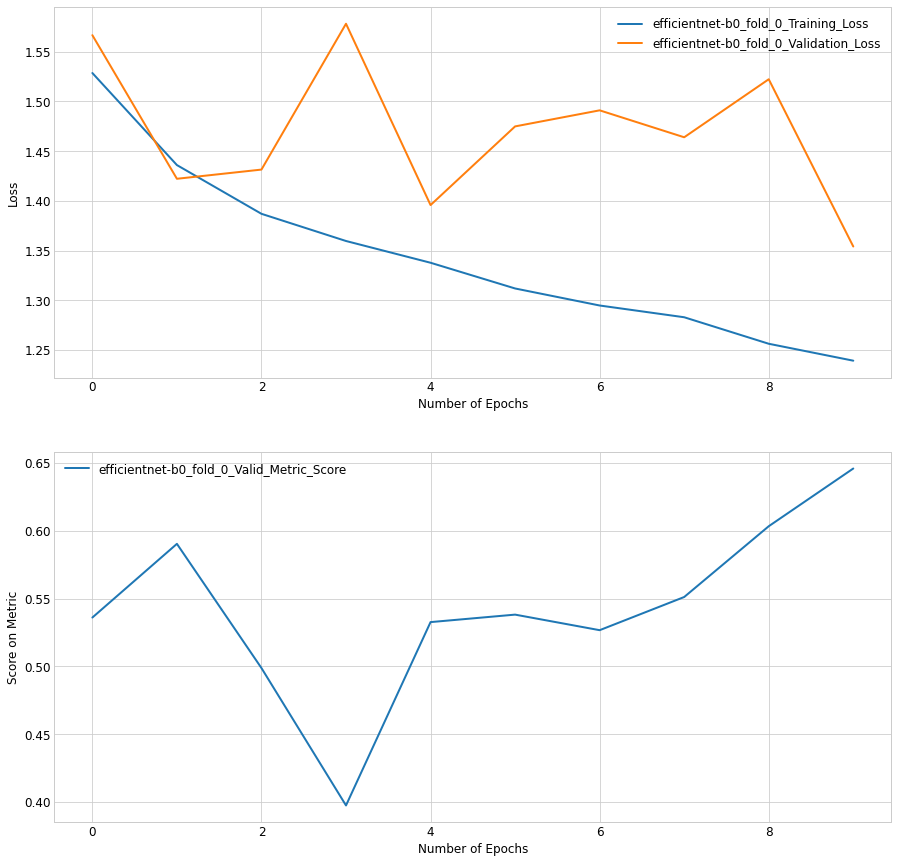

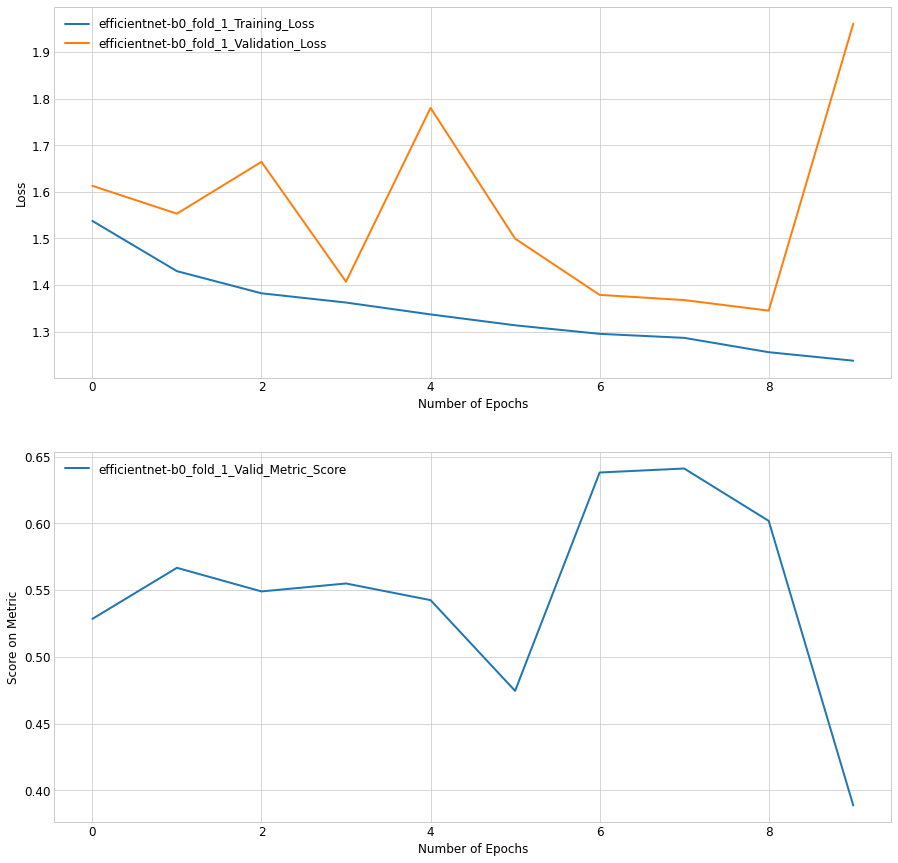

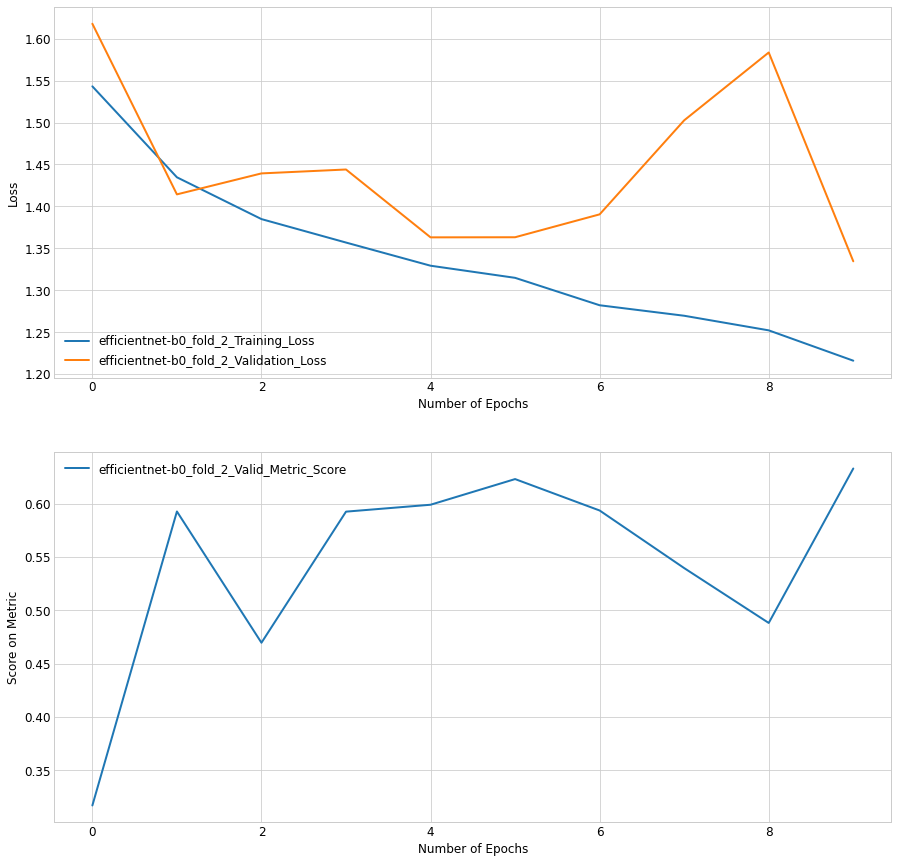

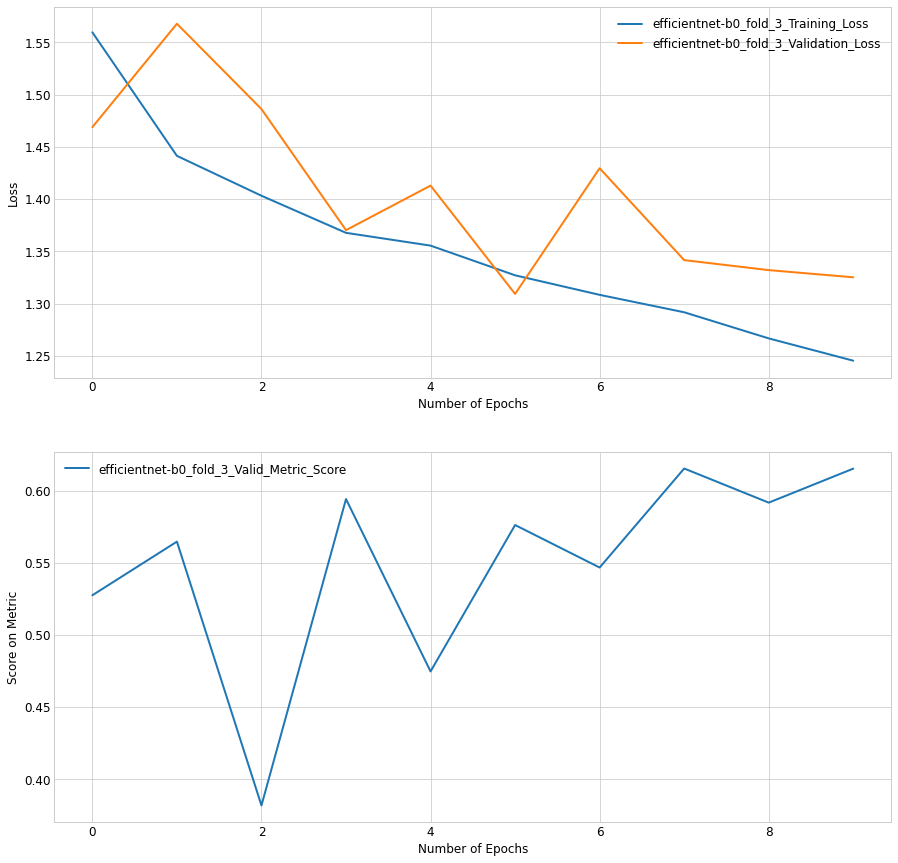

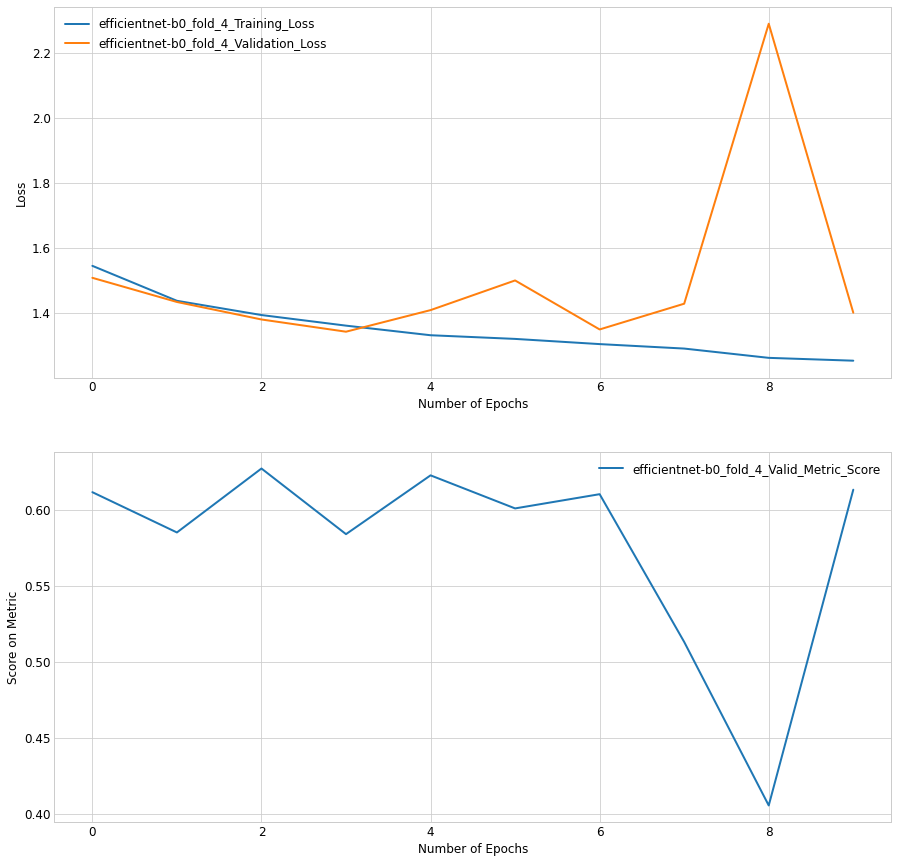

In [18]:
for fold in range(Config.num_folds):
    print(f"Fitting on Fold {fold+1}")
    #Make Train and Valid DataFrame from fold
    train_df_fold = train_df[train_df['fold'] != fold]
    valid_df_fold = train_df[train_df['fold'] == fold]
    
    #Build and load Dataset
    train_data = Build_Dataset(train_df_fold, resize=(Config.height, Config.width), mode='train', augmentations=train_transforms)
    valid_data = Build_Dataset(valid_df_fold, resize=(Config.height, Config.width), mode='train', augmentations=test_transforms)
    train_iterator = DataLoader(train_data, shuffle=True, batch_size=Config.batch_size, num_workers=Config.num_workers)
    valid_iterator = DataLoader(valid_data, batch_size=Config.batch_size, num_workers=Config.num_workers)
    
    #Initialize model, loss and optimizer
    model = enetv2('efficientnet-b0', out_dim=Config.out_dim).to(Config.device)
    loss_criterion = nn.CrossEntropyLoss().to(Config.device)
    optimizer=optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999))
    
    #Fit the model and visualize the training curves
    train_stats = fit_model(model, 'efficientnet-b0', train_iterator, valid_iterator, 
              optimizer, loss_criterion, Config.device, Config.num_epochs, fold)
    plot_training_statistics(train_stats, 'efficientnet-b0', fold)
    
    #Just making sure that the output looks neat
    print('\n')
    print('-------------------------------------------------------')
    print('\n')

# Making submission to leaderboard

We are in the Endgame now.

Le Me with Thor's voice in my head: **Bring me Models**

Okay time to fetch all our models and combine their efforts and submit the predictions to the leaderboard!

In [19]:
k_fold_models = [Config.pwd+model for model in os.listdir(Config.pwd) if 'efficientnet-b0' in model]
k_fold_models

['/kaggle/working/efficientnet-b0_fold_3.pt',
 '/kaggle/working/efficientnet-b0_fold_1.pt',
 '/kaggle/working/efficientnet-b0_fold_2.pt',
 '/kaggle/working/efficientnet-b0_fold_0.pt',
 '/kaggle/working/efficientnet-b0_fold_4.pt']

In [20]:
#This bit of code is gonna fetch predictions for a single model
def get_predictions(model, iterator, device):
    
    preds = []
    preds = np.array(preds)
    model.eval()
    
    with torch.no_grad():
        
        for (x, y) in iterator:
        
            x = x.to(device, dtype=torch.float)
            y = y.to(device, dtype=torch.long)
            y_pred = model(x)
            preds = np.append(preds, np.argmax(y_pred.detach().cpu().numpy(), axis = 1))
            
    return preds

Yeah, I know where's the testing data, how the hell are we supposed to submit when there's no file containing test data, and all those questions.

You can just copy my code below and commit the notebook and submit to the competition, but why did organisers do this? 
I guess they wanted to avoid hand labelling and data leakage, and this is really a great attempt at doing that.

But what's happening? 

When you commit at that time too the test file won't be available so don't painc, just go to your outputs click on submit for that 3 rowed submission.csv. When you finally click submit with that, they re-run your notebook(but this time on their servers) and guess what, they put the test file in the input data, exactly the way we expect them to, hence your submission returns a score on public leaderboard and is a valid submission.

For more info on this follow [this thread](https://www.kaggle.com/c/prostate-cancer-grade-assessment/discussion/145219)

In [21]:
test_df = pd.read_csv(Config.data_dir+'test.csv')
sample = pd.read_csv('../input/prostate-cancer-grade-assessment/sample_submission.csv')
test_df.drop(columns=['data_provider'], inplace=True)

def submit(sample):
    if os.path.exists(Config.test_img_dir):
        test_data = Build_Dataset(test_df, resize=(Config.height, Config.width), mode='test', augmentations=test_transforms)
        test_iterator = DataLoader(test_data, batch_size=Config.batch_size, num_workers=Config.num_workers)
        
        #Lets Ensemble all of our models and predict the most frequent(ie Voting ensemble)
        final_preds = []
        for fold in range(Config.num_folds):
            model = enetv2('efficientnet-b0', out_dim=Config.out_dim).to(Config.device)
            model.load_state_dict(torch.load(k_fold_models[fold], map_location=lambda storage, loc: storage))
            model.to(Config.device)
            preds = get_predictions(model, test_iterator, Config.device)
            final_preds.append(preds)
            
        final_preds = np.array(final_preds)
        final_preds = stats.mode(final_preds)
        sample['isup_grade'] = final_preds[0][0]
    return sample

submission = submit(sample)
submission['isup_grade'] = submission['isup_grade'].astype(int)
submission.to_csv('submission.csv', index=False)

# Acknowledgements

Last but not the least, I would like to thank Y.Nakama and Qishen Ha for their public kernels. Without their kernels, this simple kernel wouldn't have been possible.

The link to their work is

https://www.kaggle.com/haqishen/train-efficientnet-b0-w-36-tiles-256-lb0-87

https://www.kaggle.com/yasufuminakama/panda-submit-test

# Good Bye Fellas, Until next time

**If the content in this notebook inspired you, Do Upvote the notebook and show me your support**